# Table of Contents:


1.   Loading the Data
2.   Train and Test Split/ Data Processing
3.   Choosing our model architecture
4.   Building Model
5.   Prediction
6.   Evaluation
7.   Visualization



In [42]:
pip install yfinance

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf 
import yfinance as yf

## 1. Loading the Data
The Tesla and Nasdaq data are up to 29-06-2021. Let’s take the close column for the stock prediction. We can use the same strategy.

In [44]:
# Download additional stock data, which is correlated to Tesla stock, after research we found that NASDAQ is very correlated

tesla_df = yf.download(['TSLA'], 
                      start='2019-01-02', 
                      end='2021-06-30', 
                      progress=False).reset_index()
nasdq_df = yf.download(['^IXIC'], 
                      start='2019-01-02', 
                      end='2021-06-30', 
                      progress=False).reset_index()


# Events is a self made data for the major events and its effect on tesla stock over the years
events = pd.read_excel('tesla_tweed_pre.xlsx', sheet_name='tesla_tweets')[['Date', 'accum_value']]
nasdq_df.columns = ['Date', 'NSDQ-Open', 'NSDQ-High', 'NSDQ-Low', 'NSDQ-Close', 'NSDQ-Adj Close', 'NSDQ-Volume']
tesla_df.columns = ['Date', 'tesla-Open', 'tesla-High', 'tesla-Low', 'tesla-Close', 'tesla-Adj Close', 'tesla-Volume']
event_tesla_merge = pd.merge(tesla_df, events, how='left', on='Date')
data = pd.merge(event_tesla_merge, nasdq_df, how='left', on='Date')
data['accum_value']=data['accum_value'].fillna(0)

# Data transformation
def date_extraction(dataset):
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    # dataset['Year'] = pd.DatetimeIndex(dataset['Date']).year
    # dataset['Month'] = pd.DatetimeIndex(dataset['Date']).month
    # dataset['Day'] = dataset.Date.dt.day
    # dataset['DayOfWeek'] = dataset.Date.dt.dayofweek
    # dataset['WeekOfYear'] = dataset.Date.dt.weekofyear
    
    # dataset['Series'] = np.arange(1,len(data)+1)
date_extraction(data)
full_dates = pd.DataFrame(pd.date_range(start = '2019-01-02', end = '2021-06-29', freq = 'D'), columns=['Date'])
data = pd.merge(full_dates, data, how='left', on='Date').fillna(method='bfill')
data = data.set_index('Date')
data= data[['NSDQ-Close', 'NSDQ-Volume', 'accum_value', 'tesla-Volume','tesla-Close'] ]

## 2. Train and Test Split/ Data Processing
Whenever training Timeseries data we should divide the data differently we should train the data with the respective date.

Always remember that in time-series data the one data is dependent on other data. The training size should be 65% of the total length of the data frame, the test size should be the difference between the length of the dataset and the training size.

In [45]:
train_df,test_df = data[:800], data[800:]  # 75% and 25%
train_df.shape,test_df.shape

((799, 5), (110, 5))

In [46]:
X_data = data.copy()
scaler = MinMaxScaler()
X_data = pd.DataFrame(scaler.fit_transform(X_data))
X_data.columns = data.columns

In [47]:
# For this case, let's assume that
# Given past 25 days observation, forecast the next 15 days observations. 
n_past = 15
n_future = 15 
n_features = 5

In [48]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series.iloc[window_start:past_end, :], series.iloc[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [49]:
train_df,test_df = X_data[0:800], X_data[800:]


X_train, y_train = split_series(train_df,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test, y_test = split_series(test_df,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((771, 15, 5), (771, 15, 5), (81, 15, 5), (81, 15, 5))

## 3. Choosing our model 
LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is that LSTM can store past important information and forget the information that is not.
LSTM has three gates:

*   The input gate: The input gate adds information to the cell state,
*   The forget gate: It removes the information that is no longer required by the model
*   The output gate: Output Gate at LSTM selects the information to be shown as output.



 

While Implementing any LSTM, we should always reshape our X train in 3-D, add 1 the reason behind is the time step and the 1 is given to the LSTM.

**Model Architecture**

E1D1 ==> Sequence to Sequence Model with one encoder layer and one decoder layer. 

E2D2 ==> Sequence to Sequence Model with two encoder layers and two decoder layers. 

## 4. Building model
Building two LSTM model with different parameters to train

In [50]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
#
model_e1d1.summary()
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 15, 5)]      0           []                               
                                                                                                  
 lstm_12 (LSTM)                 [(None, 100),        42400       ['input_5[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector_4 (RepeatVector)  (None, 15, 100)     0           ['lstm_12[0][0]']                
                                                                                            

In [51]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=50,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=50,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])


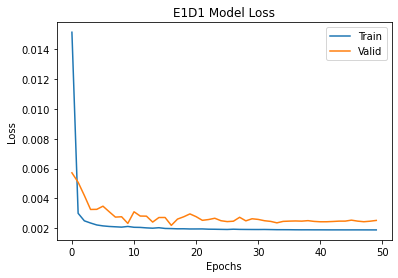

In [52]:
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("E1D1 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

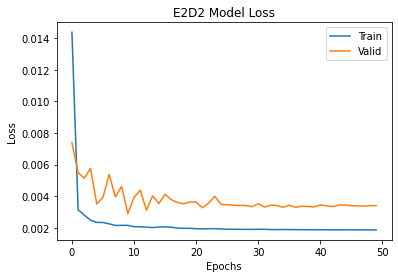

In [53]:
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

## 5. Prediction
Predict both the X_train and the X_test, now let’s scaler inverse transform because I want to see the root mean square performance.

In [54]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

## 6. Evaluation


1.   Tables with the ground truth, model1, and model 2 values
2.   Evaluation metrics (MAPE, MSE, RMSE)



In [55]:
truth = pd.DataFrame(scaler.inverse_transform(y_test[-1,:,:])[:,-1], columns=['tesla-Close'])
predict1 = pd.DataFrame(scaler.inverse_transform(pred_e1d1[-1,:,:])[:,-1], columns=['Label1'])
predict2 = pd.DataFrame(scaler.inverse_transform(pred_e2d2[-1,:,:])[:,-1], columns=['Label2'])
predict = pd.merge(predict1, predict2, right_index=True, left_index=True)
compare = pd.merge(truth, predict, right_index=True, left_index=True)
predict_date = pd.DataFrame(pd.date_range(start = '2021-06-15', end = '2021-06-29', freq = 'D'), columns=['Date'])
compare = pd.merge(compare, predict_date, right_index=True, left_index=True)
compare = compare.set_index('Date')
compare

,tesla-Close,Label1,Label2
Date,,,
2021-06-15,599.359985,657.311279,646.105408
2021-06-16,604.869995,652.549438,648.638062
2021-06-17,616.599976,644.120728,651.728699
2021-06-18,623.309998,637.682800,655.322327
2021-06-19,620.830017,633.665588,659.262634
2021-06-20,620.830017,631.570801,663.385620
2021-06-21,620.830017,630.799683,667.509216
2021-06-22,623.710022,630.855347,671.461243
2021-06-23,656.570007,631.375610,675.104431


In [56]:
compare.to_csv('LSTM.csv')

In [61]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


mape_score = mean_absolute_percentage_error(compare['tesla-Close'], compare.Label1.values)
mae_score = mean_absolute_error(compare['tesla-Close'], compare.Label1.values)
rmse_score = mean_squared_error(compare['tesla-Close'], compare.Label1.values, squared=False)

print('LSTM 1 model MAPE is: {}%'.format(round((mape_score*100),2)))
print('LSTM 1 model MAE is: {}'.format(round(mae_score, 2)))
print('LSTM 1 model RMSE is: {}'.format(round(rmse_score)))

LSTM 1 model MAPE is: 5.19%
LSTM 1 model MAE is: 33.91
LSTM 1 model RMSE is: 39


In [62]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


mape_score2 = mean_absolute_percentage_error(compare['tesla-Close'], compare.Label2.values)
mae_score2 = mean_absolute_error(compare['tesla-Close'], compare.Label2.values)
rmse_score2 = mean_squared_error(compare['tesla-Close'], compare.Label2.values,  squared=False)

print('LSTM 2 model MAPE is: {}%'.format(round((mape_score2*100),2)))
print('LSTM 2 model MAE is: {}'.format(round(mae_score2, 2)))
print('LSTM 2 model RMSE is: {}'.format(round(rmse_score2)))

LSTM 2 model MAPE is: 4.07%
LSTM 2 model MAE is: 25.34
LSTM 2 model RMSE is: 31


In [65]:
evaluation = pd.DataFrame({'LSTM1': [round((mape_score*100),2), round(mae_score, 2),round(rmse_score) ], 
              'LSTM2': [round((mape_score2*100),2), round(mae_score2, 2),round(rmse_score2) ]}, index=['MAPE', 'MAE', 'RMSE'])

evaluation.to_csv('evaluation_lstm.csv')
evaluation

,LSTM1,LSTM2
MAPE,5.19,4.07
MAE,33.91,25.34
RMSE,39.00,31.00


## 7. Visualization
Drawings the expected line curves for both models vs the ground truth

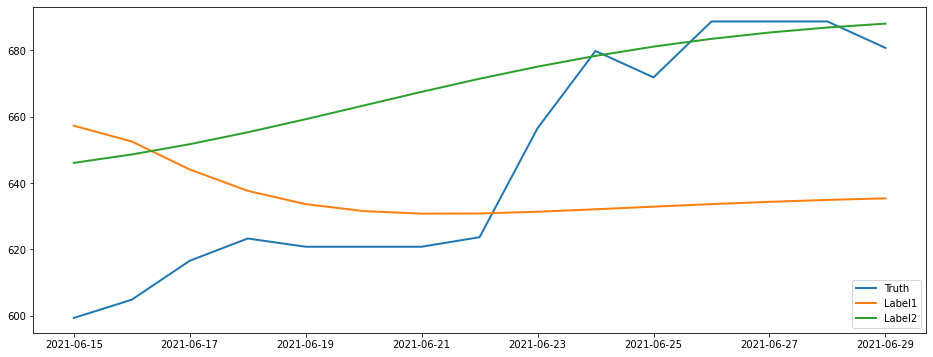

In [60]:
plt.figure(figsize=(16,6))
plt.plot(compare[['tesla-Close', 'Label1', 'Label2']], linewidth=2)
plt.legend(['Truth', 'Label1', 'Label2'], loc='lower right')
plt.show()


Blue indicates the True data

Orange indicates the first prediction data

Green indicates the second prediction data
